# Deep Bucket Lab: 
## A Playground for Understanding Hydrologic Process Representations with Deep Learning

Welcome to the Deep Bucket Lab, where the complexities of hydrologic systems are unraveled through the lens of deep learning. This notebook is an educational journey designed to help you grasp the fundamentals of simulating dynamic hydrological systems using advanced machine learning techniques.

Our tutorial models a 'leaking bucket' – a simplified yet effective representation of a hydrological system. This approachable model allows us to evaluate and understand the dynamics of water flow in a controlled, yet insightful manner.

Here, we generate all data synthetically, using numerical simulations to mimic various hydrological scenarios. You'll witness how different bucket characteristics and environmental variables, like precipitation, influence the system's behavior.

We employ a single-layer Long Short-Term Memory (LSTM) network, a type of deep learning model, to learn and predict the dynamics of water levels and fluxes in our simulated buckets, based on the 'ground truth' data we generate.

This notebook is your playground to experiment and explore. Modify the bucket model attributes, tweak the modeling setup, and delve into the fascinating world of hydrologic process representations and their predictability. Through interactive graphs and hands-on experiments, you'll gain a deeper understanding of hydrologic principles and the power of deep learning in simulating them.

Whether you're a beginner in hydrology or looking to expand your knowledge, this lab is designed to offer valuable insights in an engaging and accessible manner. By the end of this tutorial, you'll have a firmer grasp of hydrologic simulations, deep learning applications in hydrology, and the confidence to apply these concepts in real-world scenarios. Let's dive in!



# 1. Setup

The first thing to do is set up the notebook environment with all the necessary libraries, declare model global parameters, settings, variables, and functions that define the bucket system we want to represent. We also define the hyperparameters and structure for the deep learning model.

Note: In a typical full-scale modeling framework, these would be declared in a configuration file.

### 1.1 Importing Libraries

We import standard libraries for data management, calculations, and plotting. Each library plays a specific role in our modeling process: `numpy` for efficient numerical computations, `pandas` for data handling, `matplotlib` for visualizing our results, and `IPython.display` for interactive outputs in the notebook.

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

### Importing Machine Learning Libraries

In this section, we import machine learning libraries that will be used throughout this notebook. These libraries provide tools for building our model architecture, as well as for training, validating, and testing:

- `torch` and its submodules (`nn`, `optim`, etc.) from PyTorch, a leading deep learning library, for defining and training neural network models.
- `torch.utils.data` for efficient data handling and batching.
- `torch.autograd.Variable` for automatic differentiation: compute the derivatives of functions whose exact forms are known. Applies the **chain rule** to break down expressions into simpler ones.
- `sklearn.preprocessing.StandardScaler` from Scikit-learn, for scaling our data to something consistent for the learning model to use.
- `tqdm.notebook` for displaying progress bars during training and validation.

These libraries will be used in the development and evaluation of our deep learning model.


In [252]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable 
import sklearn
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import trange, tqdm

We import a library for implementing the unit hydrograph method and set up the default distribution.

In [253]:
from pyflo import system
from pyflo.nrcs import hydrology

uh484 = system.array_from_csv('distributions/scs484.csv')

### 1.2 Defining the Physical Bucket Model System

In this section, we establish the elements of our physical bucket model system.

**Global Variables:**

- `g`: Gravitational acceleration, denoted in meters per hour squared [$m/h^2$].
- `time step`: The time increment for each step in our simulation, measured in hours [$h$].

In [254]:
g = 1.271e8
time_step = 1

**Parameters for the Forcing Process (Precipitation)**

In our synthetic system, precipitation is converted to a hydrologic response. To simulate this, we use a stochastic (random) process that generates precipitation data based on probabilistic models. This process not only determines the occurrence of rain but also quantifies the total amount of rainfall during each event.

We categorize precipitation for likelihood (`rain_probability_range`) and intensity (`rain_depth_range`):
- **None**: The probability range for this type is set to ensure that dry periods are realistically simulated.
- **Light**: More frequent events with lower intensity.
- **Heavy**: Less frequent with higher intensity. Driving "overtopping" events.

These parameters allow us to create a diverse set of precipitation scenarios, each affecting the hydrological system in different ways. Precipitation is measured in [$m/h$].


In [255]:
rain_probability_range = {"None": [0.6, 0.7], 
                          "Light": [0.5, 0.8], 
                          "Heavy": [0.2, 0.3]}

rain_depth_range = {"Light": [0, 0.25], "Heavy": [0.25, 1]}

**Bucket Physical Attributes**

To simulate the dynamics of our leaky bucket system, we define a set of physical attributes that characterize each bucket. These attributes determine how the bucket interacts with the hydrological inputs (like precipitation) and influences the overall water flow dynamics. The attributes include:

- `A_bucket`: The cross-sectional area of the bucket, measured in square meters [$m^2$]. This determines the bucket's capacity to hold water.
- `H_bucket`: The height of the bucket, measured in meters [$m$]. This defines the maximum water level the bucket can sustain.
- `rA_spigot`: The ratio of the diameter of the spigot to the height of the bucket.
- `rH_spigot`: The ratio of the height of the spigot to the height of the bucket.
- `K_infiltration`: The infiltration rate (geological permeability [$\log 10$]), indicating how quickly water seeps through the bucket, measured in square meters [$m^2$].
- `ET_parameter`: The evapotranspiration parameter, representing the rate of water loss due to evaporation and transpiration, measured in meters per day [$m/day$].
- `soil_depth`: The soil depth, measured in meters [$m$]. This affects the infiltration rate.

To introduce variability and simulate different hydrological scenarios, we will generate a range of leaky buckets by randomly selecting values for these physical attributes from predefined ranges. This approach allows us to explore a wide spectrum of bucket behaviors and their responses to various hydrological conditions.

The following code block defines the possible ranges for each attribute, ensuring a diverse set of buckets for our simulations.

In [256]:
bucket_attributes_range = {"A_bucket": [10.0, 20.0],
                           "H_bucket": [5.0, 6.0],
                           "rA_spigot": [0.25, 0.3],
                           "rH_spigot": [0.1, 0.3],
                           "K_infiltration": [-15, -9],
                           "ET_parameter": [0.001, 0.004],
                           "soil_depth": [10, 20]
                          }

bucket_attributes_list = list(bucket_attributes_range.keys())
bucket_attributes_list.append('A_spigot')
bucket_attributes_list.append('H_spigot')

**Model Input and Output Variables**

The following variables represent fluxes and the state of the system:

**Inputs:**
- `precip`: Precipitation into the bucket. This variable represents the external hydrological input driving the system.
- `et` (Evapotranspiration): The actual loss of water from the bucket due to evaporation and transpiration.
- `pet` (Potential Evapotranspiration): The potential loss to evaporation, providing an upper limit to the `et` variable.

**Outputs:**
- `q_overflow`: The water flow over the bucket's rim. This occurs when the water level exceeds the bucket's capacity.
- `q_spigot`: The water flow out of the bucket's spigot. It's a controlled outflow dependent on the water level and spigot characteristics.
- `h_bucket` (Water Head): The **state** of the water level in the bucket.

These variables represent the processes and states we aim to simulate and understand. The following code block initializes these lists and calculates the number of input and output variables, setting the stage for the subsequent modeling steps.


In [257]:
input_vars = ['precip', 'et', 'infiltration']
output_vars = ['q_overflow', 'q_spigot', 'q_total']
n_input = len(input_vars)
n_output = len(output_vars)

**Data Noise**

In real-world hydrological systems, data often contains noise due to various environmental and measurement uncertainties. To make our synthetic data more representative of actual scenarios, we introduce noise into the system. We implement this by muadjusting the synthetic fluxes and state values by a random factor drawn from a normal distribution. This method simulates **some** of the random fluctuations and uncertainties inherent in real hydrological data, but not all types of biases and errors in the data are accounted for using this method.

The following code block sets up the noise parameters for our model. The `noise` dictionary specifies the standard deviation of the noise for each variable (`pet`, `et`, `q`, and `head`). By adjusting these parameters, we can simulate different levels of data quality and observe how the model responds to these changes.


In [258]:
noise = {"pet": 0.1, "et": 0.1, "q": 0.1, "head": 0.1} 

**Illustration of the Leaking Bucket Hydrological System**

Below is a schematic representation of the leaking bucket system used in our simulations. This diagram provides a visual understanding of the various components and dynamics of the system, including the bucket's structure, the spigot, and the flow of water.

<img src="figs/bucket_schematic.png" alt="Leaking Bucket System Schematic" width="250"/>


*Figure: Schematic of the Leaking Bucket Hydrological System. The diagram illustrates the key elements of the system, such as the bucket area, spigot, water inflow (precipitation), and outflows (spigot flow and overflow). Understanding this setup is crucial for comprehending how the system responds to different hydrological inputs and conditions.*

### 1.3 Defining the Modeling Setup

**Deep Learning Model (LSTM) Hyperparameters**

In this section, we define the hyperparameters for our LSTM (Long Short-Term Memory) deep learning model. These hyperparameters influence the model's learning process, its ability to capture complex patterns in the data, and its overall performance. Here's a brief overview of each hyperparameter:

- `device`: Specifies the computing device for training and inference, such as CPU or CUDA (GPU). Utilizing CUDA can significantly speed up the training process if a compatible GPU is available.
- `hidden_state_size`: The number of units in the hidden state of the LSTM. This determines the capacity of the model to learn and remember information over time.
- `num_layers`: The number of LSTM layers in the model. More layers can increase the model's complexity and ability to learn more intricate patterns.
- `num_epochs`: The number of complete passes through the training dataset. This affects how long the model will learn from the data.
- `batch_size`: The number of samples processed before the model's internal parameters are updated. It's a balance between training speed and memory usage.
- `seq_length`: The length of the input sequences. This defines how much past information the model considers for making predictions.
- `learning_rate`: The step size at each iteration while moving toward a minimum of the loss function. It's crucial for convergence of the model during training.
- `num_classes`: The number of output classes or predictions the model makes.
- `input_size`: The size of the input layer, which should match the number of features in the dataset.

Adjusting these hyperparameters **can** optimize the LSTM model's accuracy and generalization capabilities for our specific task and dataset. The following code block sets these parameters, preparing our model for training and evaluation.


In [259]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA device: ", torch.cuda.get_device_name(0))
else:
    device = 'cpu'
hidden_state_size = 16
num_layers = 8
num_epochs = 5  
batch_size = 256 
seq_length = 24
learning_rate = np.linspace(start=0.1, stop=0.01, num=num_epochs)

Using CUDA device:  NVIDIA GeForce RTX 3060


**Size of Data Records and Splits**

In deep learning, particularly for time-series data like our hydrological simulations, it's crucial to split the data into distinct sets for different stages of model development and evaluation. These splits help in effectively training the model, tuning its hyperparameters, and assessing its performance. We divide our data into three sets:

- **Training Set (`train`)**: This is the primary dataset used for training the model. Backpropagation, the process of adjusting the model's weights based on the error in its predictions, is performed on this set.
- **Validation Set (`val`)**: This dataset is used for hyperparameter tuning. It helps in optimizing the model without using the test set, thus preventing information leakage and overfitting.
- **Testing Set (`test`)**: The final evaluation of the model's accuracy is done on this dataset. Note that this data is **never** used in the training process to ensure an unbiased assessment of the model's performance.

We will define the number of randomly generated bucket configurations for each of these sets (`n_buckets_split`) as well as the length of the simulations (number of time steps) for each set (`time_splits`).

For instance, if we have 10 different buckets in the training set, each with 1000 time steps, we will train the model on these 10 bucket configurations, each simulated over 1000 time steps. This approach allows us to capture a diverse range of system behaviors and responses, ensuring that our model is robust and generalizable.

The following code block sets the number of buckets and time steps for each data split, laying the groundwork for our model training and evaluation process.

In [260]:
n_buckets_split = {"train": 10, "val": 5,"test": 1}
time_splits = {"train": 1000, "val": 500,"test": 500}

In order to manage our data for training, validation, and testing, we calculate the total length of the data record we need to generate, as well as the total number of bucket configurations we will use across all splits. These calculations are based on the settings we defined earlier for the time steps and bucket splits.

- `num_records`: This variable represents the total length of the data record. It is calculated by summing the number of time steps allocated for the training, validation, and testing sets, along with additional steps to account for the sequence length in each phase. This ensures we have a comprehensive dataset that covers all aspects of our model's training and evaluation process.

- `n_buckets`: This variable indicates the total number of unique bucket configurations we will use. It is the sum of the number of buckets allocated for training, validation, and testing. This diversity in bucket configurations is key to ensuring that our model is trained and tested on a wide range of scenarios, enhancing its robustness and generalizability.

<img src="./figs/bucket_splits.png" alt="Sample Image" width="200"/>

The following code block performs these calculations, setting the stage for the subsequent data generation and modeling steps.


In [261]:
num_records = time_splits["train"] + time_splits["val"] + time_splits["test"] + seq_length * 3
n_buckets = n_buckets_split["train"] + n_buckets_split["val"] + n_buckets_split["test"]

To effectively train, validate, and test our deep learning model, we use separate datasets for each phase. This process involves calculating specific parameters for bucket configurations and time steps that correspond to our training, validation, and testing sets. These parameters will ensure that each dataset is distinct and suitable for its respective purpose in the model development process.

- **Bucket Splits**: We calculate the indices of buckets to be used for each set (training, validation, testing) based on the predefined number of buckets for each phase. This ensures a diverse range of bucket configurations for the model to learn from and be evaluated against.

- **Time Splits**: We determine the time range for each dataset, ensuring that the model is trained, validated, and tested on different segments of the data. This segmentation is crucial for assessing the model's ability to generalize and perform accurately on unseen data.

The following code block defines a function `split_parameters` that performs these calculations. It creates lists of bucket indices for each set and determines the time range for each set based on the given time splits. The function then organizes these split parameters into separate lists for the training, validation, and testing sets, facilitating the subsequent data preparation and modeling steps.


In [262]:
def split_parameters():
    # create lists of bucket indices for each set based on the given bucket splits
    buckets_for_training = list(range(0, n_buckets_split['train'] + 1))
    buckets_for_val = list(range(n_buckets_split['train'] + 1, 
                                 n_buckets_split['train'] + n_buckets_split['val'] + 1))
    buckets_for_test = list(range(n_buckets - n_buckets_split['test'], n_buckets))

    # determine the time range for each set based on the given time splits
    train_start = seq_length
    train_end   = time_splits["train"]
    val_start   = train_end + seq_length
    val_end     = val_start + time_splits["val"]
    test_start  = val_end + seq_length
    test_end    = test_start + time_splits["test"]
    
    # organize the split parameters into separate lists for each set
    train_split_parameters = [buckets_for_training, train_start, train_end]
    val_split_parameters = [buckets_for_val, val_start, val_end]
    test_split_parameters = [buckets_for_test, test_start, test_end]
    
    return [train_split_parameters, val_split_parameters, test_split_parameters]

Now that we have defined our function to calculate the split parameters, it's time to run it. Executing the `split_parameters` function will allocate the specific bucket indices and time ranges for our training, validation, and testing sets. This step organizes our data into structured segments, each tailored for a specific phase of the model's development and evaluation process.

By running this function, we'll obtain the following:

- A list of bucket indices for the training set (`buckets_for_training`) and the corresponding start and end time steps (`train_start`, `train_end`).
- A similar list and time steps for the validation set (`buckets_for_val`, `val_start`, `val_end`).
- And the same for the testing set (`buckets_for_test`, `test_start`, `test_end`).

This organization ensures that each part of our dataset is used effectively in the model's training and evaluation, contributing to a more robust and accurate learning process.


In [263]:
[[buckets_for_training, train_start, train_end],
[buckets_for_val, val_start, val_end],
[buckets_for_test, test_start, test_end]]= split_parameters()

### 1.4 Creating a Sample of Diverse Buckets

With the parameters for our bucket and time splits established, our next step is to generate a diverse sample of buckets for our simulations. This diversity is key to creating a robust model that can generalize well across various hydrological scenarios.

We achieve this by randomly sampling from the possible ranges for each bucket attribute that we defined earlier. This process involves creating buckets with varying physical characteristics such as area, height, spigot size, and infiltration rates. By doing so, we ensure that our model encounters and learns from a wide array of system behaviors and responses.

The following code block will generate this sample of buckets, each with its unique set of boundary and initial conditions. This step builds a comprehensive dataset that reflects the variability and complexity of real-world hydrological systems, thereby enhancing the learning and predictive capabilities of our LSTM model.


In [264]:
def setup_buckets(n_buckets):
    # Boundary conditions
    buckets = {bucket_attribute:[] for bucket_attribute in bucket_attributes_list}
    buckets['A_spigot'] = []
    buckets['H_spigot'] = []
    for i in range(n_buckets):
        for attribute in bucket_attributes_list:
            if attribute != 'A_spigot' and attribute != 'H_spigot':
                buckets[attribute].append(np.random.uniform(bucket_attributes_range[attribute][0], 
                                                        bucket_attributes_range[attribute][1]))
        buckets['A_spigot'].append(buckets['A_bucket'][i] * buckets['rA_spigot'][i])
        buckets['H_spigot'].append(buckets['H_bucket'][i] * buckets['rH_spigot'][i])

    # Initial conditions
    h_water_level = [np.random.uniform(0, buckets["H_bucket"][i]) for i in range(n_buckets)]
    mass_overflow = [np.random.random() for i in range(n_buckets)]

    return buckets, h_water_level, mass_overflow

Next, we proceed to run the `setup_buckets` function. This function is responsible for initializing our bucket configurations based on the number of buckets we've determined to use in our simulations. It sets up the initial conditions and physical attributes for each bucket in our model.

By executing `setup_buckets`, we will achieve the following:

- `buckets`: This variable will hold the array of bucket configurations, each with its unique set of physical attributes as defined earlier.
- `h_water_level`: This represents the initial water level in each bucket.
- `mass_overflow`: This variable tracks the overflow mass from each bucket.

The setup of these buckets establishes the diverse conditions under which our LSTM model will learn and make predictions. This diversity is key to ensuring that our model is robust and can generalize well across different hydrological systems.


In [265]:
buckets, h_water_level, mass_overflow = setup_buckets(n_buckets)

### 1.5 Creating the Synthetic "Precipitation"

Synthetic precipitation data serves as the main input (forcing data) for each bucket model. This step involves creating time series data that mimic real-world rainfall patterns, influencing how our model simulates water flow and dynamics within each bucket.

The process of generating this synthetic precipitation data includes two main steps:

1. **Assigning Rainfall Parameters**: For each bucket, we randomly assign rainfall parameters based on the probability ranges specified for each precipitation type (None, Light, and Heavy). These parameters determine the likelihood and intensity of rainfall events, thereby influencing the hydrological behavior of each bucket.

2. **Generating Forcing Data**: Using the assigned rainfall parameters, we then generate the synthetic input time series for each bucket. This involves a stochastic process that simulates realistic precipitation patterns over time, based on the probability and depth ranges of each precipitation type.

The function `pick_rain_params` defined in the following code block is responsible for randomly selecting these rainfall parameters for each bucket. This function ensures that each bucket experiences a unique set of precipitation conditions, adding to the diversity and realism of our simulations.


In [266]:
def pick_rain_params():
    buck_rain_params = [rain_depth_range,
                        np.random.uniform(rain_probability_range["None"][0],
                                            rain_probability_range["None"][1]),
                        np.random.uniform(rain_probability_range["Heavy"][0],
                                            rain_probability_range["Heavy"][1]),
                        np.random.uniform(rain_probability_range["Light"][0],
                                            rain_probability_range["Light"][1])
                 ]
    return buck_rain_params

### Generate Random Rain

The next step in our simulation is to generate random rain events. This process is key to creating realistic and varied hydrological conditions for each bucket. The random rain function simulates precipitation events based on probabilities and patterns that mimic real-world weather conditions.

The `random_rain` function defined in the following code block takes into account:

- The probability of having no rain, light rain, or heavy rain, based on the parameters assigned to each bucket.
- The intensity of the rain, which is determined by a random process within specified depth ranges for light and heavy rain.
- The influence of preceding rainfall conditions. For instance, the likelihood of a certain type of rain (light or heavy) can depend on the rainfall of the previous time step.

This stochastic approach to generating rain ensures that each bucket experiences a dynamic and varied set of precipitation events. Such variability is essential for testing and training our model to handle a wide range of hydrological scenarios, enhancing its robustness and predictive accuracy.


In [267]:
def random_rain(preceding_rain, bucket_rain_params):
    depth_range, no_rain_probability, light_rain_probability, heavy_rain_probability = bucket_rain_params
    # some percent of time we have no rain at all
    if np.random.uniform(0.01, 0.99) < no_rain_probability:
        rain = 0

    # When we do have rain, the probability of heavy or light rain depends on the previous hour's rainfall
    else:
        # If last hour was a light rainy hour, or no rain, then we are likely to have light rain this hour
        if preceding_rain < depth_range["Light"][1]:
            if np.random.uniform(0, 1) < light_rain_probability:
                rain = np.random.uniform(0, 1)
            else:
                # But if we do have heavy rain, then it could be very heavy
                rain = np.random.uniform(depth_range["Heavy"][0], depth_range["Heavy"][1])

        # If it was heavy rain last hour, then we might have heavy rain again this hour
        else:
            if np.random.uniform(0, 1) < heavy_rain_probability:
                rain = np.random.uniform(0, 1)
            else:
                rain = np.random.uniform(depth_range["Light"][0], depth_range["Light"][1])
    return rain

Now that we have established the mechanism for generating random rain events, our next step is to create a rainfall input time series for each bucket in our simulation. This time series will drive the hydrological processes within each bucket.

We accomplish this by iterating over each bucket and generating a sequence of rainfall events using the `random_rain` function. The parameters for each bucket's rainfall events are determined by the `pick_rain_params` function, ensuring that each bucket experiences a unique pattern of precipitation.

The generated rainfall data for each bucket is stored in a dictionary, `in_list`, where each key corresponds to a bucket, and the value is the list of rainfall amounts over time. This structure allows us to efficiently manage and access the rainfall data for each bucket, facilitating the subsequent steps in our simulation and modeling process.

The following code block iterates through all the buckets, generating and storing the random rainfall time series for each.

In [268]:
in_list = {}
for ibuc in range(n_buckets):
    bucket_rain_params = pick_rain_params()
    in_list[ibuc] = [0]
    for i in range(1, num_records):
        in_list[ibuc].append(random_rain(in_list[ibuc][i-1], bucket_rain_params))

### 1.6 Running Numerical Simulations of the Bucket Model to Generate "Ground Truth" Data

To develop a reliable and accurate deep learning model, we need "ground truth" data. In our case, the "ground truth" data is generated by running numerical simulations of the bucket model.

For each bucket configuration, the simulation iterates over each time step, updating the water level based on factors such as precipitation, evapotranspiration, infiltration, overflow, and spigot outflow. The results of these simulations, including key variables like water level, overflow, and spigot flow, are recorded and stored in a data frame. This provides a concise yet comprehensive representation of the bucket model's behavior over time.

The function `run_bucket_simulation` defined in the following code block is responsible for performing these simulations. It takes into account all the physical attributes and dynamic inputs of each bucket, ensuring that the generated data accurately reflects the complex interactions and processes within the hydrological system. This ground truth data provides the real-world scenarios and responses that the model needs to learn and replicate.


In [269]:
def run_bucket_simulation(ibuc):
    columns = ['precip', 'et', 'infiltration', 'h_bucket', 'q_overflow', 'q_spigot', 'q_total']
    columns.extend(bucket_attributes_list)
    # Memory to store model results
    df = pd.DataFrame(index=list(range(len(in_list[ibuc]))), columns=columns)
    
    # Main loop through time
    for t, precip_in in enumerate(in_list[ibuc]):
        
        # Add the input mass to the bucket
        h_water_level[ibuc] = h_water_level[ibuc] + precip_in

        # Lose mass out of the bucket. Some periodic type loss, evaporation, and some infiltration...

        # ET (m/s) is the value at each time step taking diurnal fluctuations into account. The definite integral of the following function
        # (excluding noise) from 0 to 24 is equal to ET_parameter, which is measured in m/day.
        et = np.max([0, ((1/7.6394)* buckets["ET_parameter"][ibuc]) * np.sin((np.pi / 12)*t) * np.random.normal(1, noise['pet'])])

        # Calculate change in height due to infiltration using Darcy's Law. Divide Q (m^3/s) by A_bucket (m^2) to get infiltration (m/s)
        # Q = (k * rho * g * A_bucket * delta_h) / (mu * L)
        # infiltration = (k * rho * g * delta_h) / (mu * L)

        # k = K_infiltration = geologic permeability (m^2)
        # rho = density of water, constant, ~1000 kg/m^3
        # g = gravitational constant, ~9.807 m/s^2
        # mu = viscosity of water, constant , ~0.001 Pa/s
        # L = soil depth (m)
        # delta_h = hydraulic head/soil water potential (m) = soil depth + h_water_level
        # infitration = flow (m/s)

        k = 10 ** buckets['K_infiltration'][ibuc]
        L = buckets['soil_depth'][ibuc]
        delta_h = h_water_level[ibuc] + L

        infiltration = k * delta_h / L

        h_water_level[ibuc] = np.max([0 , (h_water_level[ibuc] - et)])
        h_water_level[ibuc] = np.max([0 , (h_water_level[ibuc] - infiltration)])
        h_water_level[ibuc] = h_water_level[ibuc] * np.random.normal(1, noise['et'])

        # Overflow if the bucket is too full
        # mass_overflow is measured in m/s bc normalized by basin area
        if h_water_level[ibuc] > buckets["H_bucket"][ibuc]:
            mass_overflow[ibuc] = h_water_level[ibuc] - buckets["H_bucket"][ibuc]
            h_water_level[ibuc] = buckets["H_bucket"][ibuc] 
            h_water_level[ibuc] = h_water_level[ibuc] - np.random.uniform(0, noise['q'])

        # Calculate head on the spigot
        h_head_over_spigot = (h_water_level[ibuc] - buckets["H_spigot"][ibuc] ) 
        h_head_over_spigot = h_head_over_spigot * np.random.normal(1, noise['head'])

        # Calculate water leaving bucket through spigot
        if h_head_over_spigot > 0:
            velocity_out = np.sqrt(2 * g * h_head_over_spigot)
            spigot_out_volume = velocity_out *  buckets["A_spigot"][ibuc] * time_step
            
            # prevents spigot from draining water below H_spigot
            # spigot flow measured in m/s bc normalized by basin area
            spigot_out = np.min([spigot_out_volume / buckets["A_bucket"][ibuc], h_head_over_spigot])
            h_water_level[ibuc] -= spigot_out
        else:
            spigot_out = 0

        # Save the data in time series
        df.loc[t,'precip'] = precip_in
        df.loc[t,'et'] = et
        df.loc[t,'infiltration'] = infiltration
        df.loc[t,'h_bucket'] = h_water_level[ibuc]
        df.loc[t,'q_overflow'] = mass_overflow[ibuc]
        df.loc[t,'q_spigot'] = spigot_out
        for attribute in bucket_attributes_list:
            df.loc[t, attribute] = buckets[attribute][ibuc]

        mass_overflow[ibuc] = 0
    
    # Set up basin for unit hydrograph transformation
    basin = hydrology.Basin(
        area = buckets["A_bucket"][ibuc] / 4047, # transform sq meters to acres -- "the delineated region concentrating to a point"
        cn=83.0, # "an empirical parameter for predicting direct runoff" 
        tc=2.3, # "estimated time of concentration in minutes" 
        runoff_dist=uh484, # "unscaled unit hydrograph runoff distribution"
        peak_factor=1 # v"alue for scaling peak runoff"
    )

    # Set up input array for unit hydrograph transformation
    q_total_inputs = np.zeros(shape=(len(df), 2))
    q_total_untrans_sum = 0

    for i in range(len(df)):
        # q_total = q_overflow + q_spigot, transform m to in.
        q_total_untrans_sum += (df.loc[i,'q_overflow'] + df.loc[i,'q_spigot']) * 39.3701 
        q_total_inputs[i] = (i, q_total_untrans_sum)      
    
    print("Untransformed sum in m: " + str(q_total_untrans_sum / 39.3701)) 

    # Transform q_total using unit hydrograph method
    q_total_hyd = basin.flood_hydrograph(q_total_inputs, interval=1)
    q_total = q_total_hyd[:,1]
    q_total_trans_sum = 0

    for i in range(len(df)):
        df.loc[i,'q_total'] = q_total[i] / 35.315 / buckets["A_bucket"][ibuc] * 3600 # transform cfs to m^3/hr, normalize q by basin area
        q_total_trans_sum += df.loc[i,'q_total']

    print("Transformed sum in m: " + str(q_total_trans_sum))

    return df

Having established the function to run our bucket model simulations, the next step is to execute these simulations for each bucket configuration and store the results.

We use a dictionary, `bucket_dictionary`, to store the simulation results. Each key in this dictionary corresponds to a specific bucket index, and the value is the data frame containing the simulation results for that bucket. This structure allows for efficient organization and retrieval of the simulation data, which is essential for the subsequent analysis and model training.

The following code block iterates through all the buckets, running the `run_bucket_simulation` function for each. This function generates the time series data for each bucket, reflecting how its water level and flow rates change over time in response to the input conditions. By storing these results in `bucket_dictionary`, we create an accessible record of each bucket's behavior, forming the basis for training and evaluating our LSTM model.


In [270]:
bucket_dictionary = {}
for ibuc in range(n_buckets):
    bucket_dictionary[ibuc] = run_bucket_simulation(ibuc)

Untransformed sum in m: 339.31599679076277
Transformed sum in m: 451.194973198372
Untransformed sum in m: 351.2579789806917
Transformed sum in m: 464.9257690634847
Untransformed sum in m: 394.788823095853
Transformed sum in m: 522.9532483461109
Untransformed sum in m: 406.079942071454
Transformed sum in m: 536.6136384481707
Untransformed sum in m: 392.8381289603742
Transformed sum in m: 522.5085871634805
Untransformed sum in m: 436.57186152284834
Transformed sum in m: 573.9760308724934
Untransformed sum in m: 368.1493508250931
Transformed sum in m: 485.63784008065187
Untransformed sum in m: 366.86206057420924
Transformed sum in m: 487.91031572995854
Untransformed sum in m: 361.1026392076444
Transformed sum in m: 479.1247343521674
Untransformed sum in m: 384.4478999720943
Transformed sum in m: 510.42141921042577
Untransformed sum in m: 360.96137002252834
Transformed sum in m: 480.541267650811
Untransformed sum in m: 392.2835779092613
Transformed sum in m: 519.6340225123716
Untransformed

### 1.7 Visualizing a Sample of the Bucket Fluxes

After running our simulations, we visually inspect the results to ensure that the model is behaving as expected. Visualization helps us confirm the presence of fluxes and validate the realism of the generated values, particularly for spigot (channel flow) and overflow (flooding) scenarios.

The function `viz_simulation` is designed to plot the model simulations for a given bucket. This visualization includes:

- **Model Inputs**: A plot of the input variables (such as precipitation and evapotranspiration) over time. This helps us understand the driving forces behind the bucket's hydrological behavior.
- **Model Outputs**: A plot of the output variables (such as overflow and spigot flow) along with the water level in the bucket over time. This gives us insight into the system's response to the inputs.

By examining these plots, we can assess whether the fluxes and water levels are within realistic ranges and behaving as expected under different conditions. This step is crucial for verifying the accuracy and reliability of our simulations before proceeding to model training.

The following code block defines the `viz_simulation` function and demonstrates how to visualize the simulation results for a selected bucket. This visual inspection is an integral part of the modeling process, ensuring that our data is suitable for training the LSTM model.


In [271]:
def viz_simulation(ibuc):
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    print('Bucket:', ibuc)
    print("Overflow mean (m/h):", np.round(bucket_dictionary[ibuc].q_overflow.mean(),2))
    print("Overflow max (m/h):", np.round(bucket_dictionary[ibuc].q_overflow.max(),2))
    print("Bucket area (m^2): ", np.round(bucket_dictionary[ibuc].A_bucket[0],2))
    print("Spigot area (m^2): ", np.round(bucket_dictionary[ibuc].A_spigot[0],2))
    print("Bucket height (m): ", np.round(bucket_dictionary[ibuc].H_bucket[0],2))
    print("Spigot height (m): ", np.round(bucket_dictionary[ibuc].H_spigot[0],2))
    print("Geologic permeability (m^2): 1e", np.round(bucket_dictionary[ibuc].K_infiltration[0],2))
    print("ET (m/day): ", np.round(bucket_dictionary[ibuc].ET_parameter[0],2))
    print("Soil depth (m): ", np.round(bucket_dictionary[ibuc].soil_depth[0],2))

    bucket_dictionary[ibuc].loc[:100,input_vars].plot(ax=ax1)
    bucket_dictionary[ibuc].loc[:100,output_vars].plot(ax=ax2)
    bucket_dictionary[ibuc].loc[:100,"h_bucket"].plot(ax=ax2)
    ax1.set_title('Model inputs')
    ax1.set_xlabel('Time (h)')
    ax1.set_ylabel('Inputs (m)')
    ax2.set_title('Model outputs')
    ax2.set_xlabel('Time (h)')
    ax2.set_ylabel('Output (m)')
    plt.legend()
    plt.show()
    plt.close()

Now, let's visualize the simulation results for the buckets in our validation set. This will help us assess the model's performance on different bucket configurations and ensure that the simulated fluxes are realistic and consistent with our expectations.

Bucket: 11
Overflow mean (m/h): 0.0
Overflow max (m/h): 0.88
Bucket area (m^2):  18.44
Spigot area (m^2):  5.09
Bucket height (m):  5.21
Spigot height (m):  1.13
Geologic permeability (m^2): 1e -12.08
ET (m/day):  0.0
Soil depth (m):  18.39


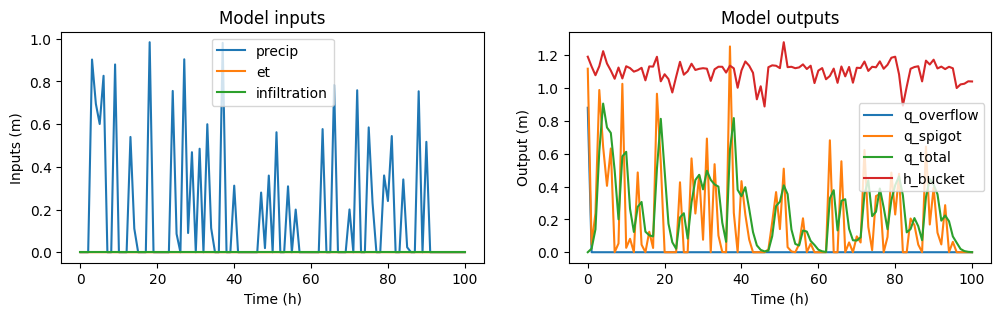

Bucket: 12
Overflow mean (m/h): 0.0
Overflow max (m/h): 0.59
Bucket area (m^2):  18.76
Spigot area (m^2):  5.35
Bucket height (m):  5.23
Spigot height (m):  0.88
Geologic permeability (m^2): 1e -11.46
ET (m/day):  0.0
Soil depth (m):  17.68


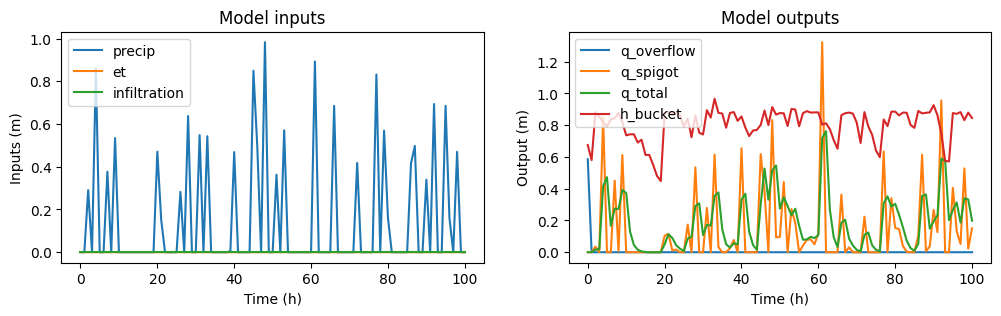

Bucket: 13
Overflow mean (m/h): 0.0
Overflow max (m/h): 0.06
Bucket area (m^2):  10.46
Spigot area (m^2):  3.02
Bucket height (m):  5.55
Spigot height (m):  0.91
Geologic permeability (m^2): 1e -12.23
ET (m/day):  0.0
Soil depth (m):  12.29


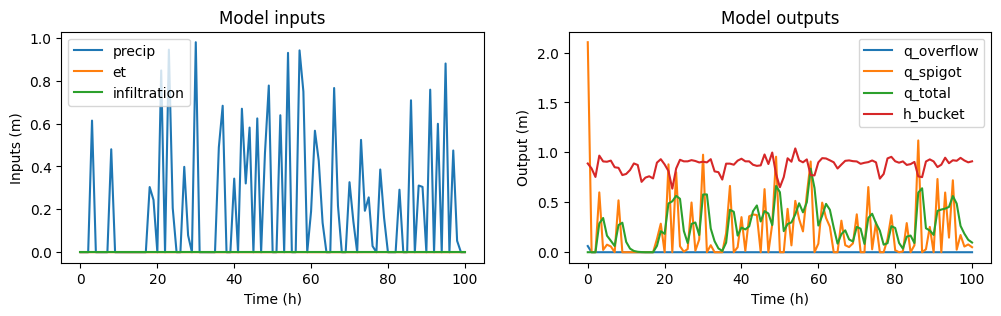

Bucket: 14
Overflow mean (m/h): 0.0
Overflow max (m/h): 0.4
Bucket area (m^2):  11.73
Spigot area (m^2):  2.97
Bucket height (m):  5.33
Spigot height (m):  0.77
Geologic permeability (m^2): 1e -12.53
ET (m/day):  0.0
Soil depth (m):  16.13


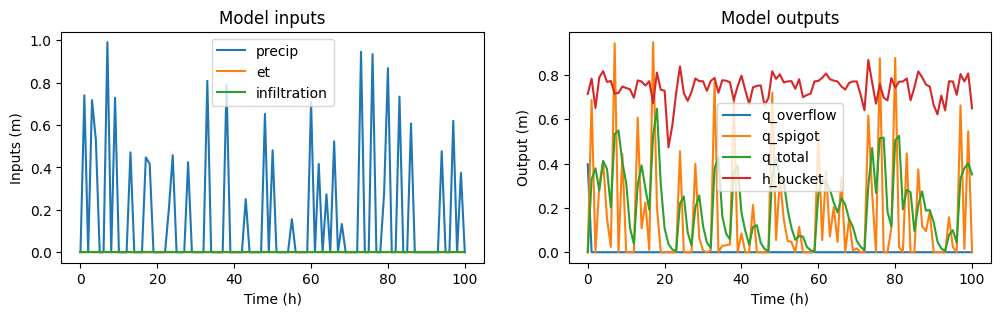

Bucket: 15
Overflow mean (m/h): 0.0
Overflow max (m/h): 0.4
Bucket area (m^2):  13.17
Spigot area (m^2):  3.83
Bucket height (m):  5.37
Spigot height (m):  1.49
Geologic permeability (m^2): 1e -14.4
ET (m/day):  0.0
Soil depth (m):  17.87


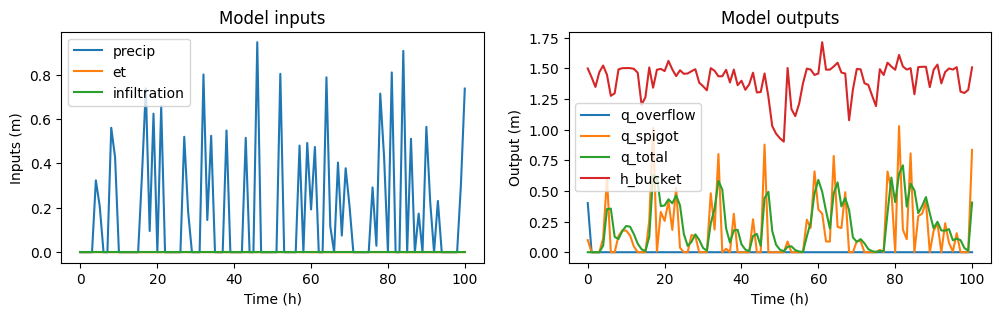

In [272]:
for ibuc in buckets_for_val:
    viz_simulation(ibuc)

# 2. Deep Learning Model

In this section, we will set up our deep learning model and outline the training procedure. The model will be trained on the "ground truth" data generated from our bucket simulations, learning to predict hydrological behaviors based on various inputs.

### 2.1 Defining the Neural Network Model

Now we use the data from our previous simulations to train a deep learning model. This process involves learning from the generated data and making predictions based on that learning. Our goal is to use the simulations to extract valuable insights and apply them in our learning and prediction processes.

We define a class called `LSTM1`, which is a PyTorch module for a single-layer Long Short-Term Memory (LSTM) network. Here's a brief overview of its structure and functionality:

- **Input**: The module takes a tensor `x` of shape `(batch_size, seq_length, input_size)`, representing a sequence of `batch_size` samples, each of length `seq_length`, with `input_size` features at each time step.
- **LSTM Layer**: Defined using the `nn.LSTM` class, it specifies the size of the input layer (`input_size`) and the hidden state (`hidden_size`). The `batch_first=True` parameter indicates that the first dimension of the input tensor is the batch size.
- **Activation Functions**: The output of the LSTM layer passes through a ReLU activation function for non-linearity.
- **Fully Connected Layer**: A linear layer (`nn.Linear`) with `num_classes` output units to generate the final predictions.
- **Forward Method**: This method processes the input tensor `x`, along with an optional tuple `init_states` representing the initial hidden and internal states of the LSTM layer, and returns the output tensor prediction. If `init_states` is not provided, it initializes as a tensor of zeros.

This LSTM model is designed to capture the temporal dynamics of our hydrological system, learning to predict future states based on past observations.

In [91]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, batch_size, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length 
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc_1 =  nn.Linear(hidden_size, num_classes) #fully connected 1
   
    def forward(self, x, init_states=None):

        if init_states is None:
            h_t = Variable(torch.zeros(1, x.size(0), self.hidden_size, device=device)) # hidden state
            c_t = Variable(torch.zeros(1, x.size(0), self.hidden_size, device=device)) # internal state
            init_states = (h_t, c_t)
           
        out, _ = self.lstm(x, init_states)
        out = self.relu(out)
        prediction = self.fc_1(out) # Dense, fully connected layer
        
        return prediction

### 2.2 Defining a Procedure for Model Validation

Model validation helps us verify that the model is functioning as expected, especially when we make changes to hyperparameters. Validation ensures that our model can accurately predict outcomes based on the input data and that it generalizes well to unseen data.

In this part of the notebook, we define a function to validate and test the LSTM model. This function also checks the water balance of the system, an important aspect of ensuring the model's accuracy in simulating hydrological processes. Here's a brief overview of what the function does:

- **Model Prediction**: It uses the pre-defined LSTM model to make predictions on the validation data.
- **Performance Metrics**: The function computes two key metrics, the Nash-Sutcliffe Efficiency (NSE), for the `spigot_out` and `mass_overflow` columns of the dataframe. These metrics help us understand how well the model's predictions match the actual data.
- **Visualization**: We plot the actual `spigot_out` and `mass_overflow` values against their corresponding LSTM predictions. This visual comparison is crucial for assessing the model's performance.
- **Water Balance Check**: The function sums up the input (precipitation), evapotranspiration, mass overflow, spigot outflow, and the last recorded water level, comparing this to the total mass out of or left in the system. This check ensures that the model accurately represents the water balance in the system.
- **Mass Residual**: We calculate and print out the percent mass residual as a measure of the system's balance.

This validation procedure is essential for ensuring that our model is reliable and effective in simulating the complex dynamics of hydrological systems.


In [92]:
def check_validation_period(lstm, np_val_seq_X, ibuc, n_plot=100):
    
    def __make_prediction():
        lstm_output_val = lstm(torch.Tensor(np_val_seq_X[ibuc]).to(device=device))
        val_spigot_prediction = []
        val_overflow_prediction = []
        for i in range(lstm_output_val.shape[0]):
            val_spigot_prediction.append((lstm_output_val[i,-1,1].cpu().detach().numpy() * \
                                    np.std(df.loc[train_start:train_end,'q_spigot'])) + \
                                   np.mean(df.loc[train_start:train_end,'q_spigot']))

            val_overflow_prediction.append((lstm_output_val[i,-1,0].cpu().detach().numpy() * \
                                    np.std(df.loc[train_start:train_end,'q_overflow'])) + \
                                   np.mean(df.loc[train_start:train_end,'q_overflow']))
        return val_spigot_prediction, val_overflow_prediction
    
    def __compute_nse():
        spigot_out = df.loc[val_start:val_end, 'q_spigot']
        spigot_mean = np.mean(spigot_out)
        spigot_pred_variance = 0
        spigot_obs_variance = 0

        overflow_out = df.loc[val_start:val_end, 'q_overflow']
        overflow_mean = np.mean(overflow_out)
        overflow_pred_variance = 0
        overflow_obs_variance = 0

        for i, pred_spigot in enumerate(val_spigot_prediction):
            t = i + seq_length - 1
            spigot_pred_variance += np.power(( pred_spigot          - spigot_out.values[t]), 2)
            spigot_obs_variance  += np.power(( spigot_mean          - spigot_out.values[t]), 2)

        for i, pred_overflow in enumerate(val_overflow_prediction):
            t = i + seq_length - 1
            overflow_pred_variance += np.power((pred_overflow          - overflow_out.values[t]), 2)
            overflow_obs_variance  += np.power((overflow_mean          - overflow_out.values[t]), 2)
        spigot_nse = np.round( 1 - ( spigot_pred_variance / spigot_obs_variance   ), 4)
        overland_flow_nse = np.round( 1 - ( overflow_pred_variance / overflow_obs_variance ), 4)
        return spigot_nse, overland_flow_nse

    def __compute_mass_balance():
        mass_in = df.sum()['precip']
        mass_out = df.sum()['et'] + \
                   df.sum()['q_overflow'] + \
                   df.sum()['q_spigot'] + \
                   df.loc[num_records - 1, 'h_bucket']
        return mass_in, mass_out

        
    df = bucket_dictionary[ibuc]
    val_spigot_prediction, val_overflow_prediction = __make_prediction()
    spigot_nse, overland_flow_nse = __compute_nse()
    mass_in, mass_out = __compute_mass_balance()
        
    print("Spigot NSE", spigot_nse)
    print("Overflow NSE", overland_flow_nse)
    print("Mass into the system: ", mass_in)
    print("Mass out or left over:", mass_out)
    print("percent mass resudual: {:.0%}".format((mass_in - mass_out) /mass_in))
    
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.plot(df.loc[val_start + seq_length-1:val_start+n_plot+seq_length - 1,'q_spigot'].values, label="Spigot out")
    ax1.plot(val_spigot_prediction[:n_plot], label="LSTM spigot out")
    ax1.legend()
    ax2.plot(df.loc[val_start+seq_length-1:val_start+n_plot+seq_length-1,'q_overflow'].values, label="Overflow")
    ax2.plot(val_overflow_prediction[:n_plot], label="LSTM Overflow")
    ax2.legend()
    plt.show()
    plt.close()

### 2.3 Instantiating the Neural Network Model (LSTM)

Now that we have defined our LSTM model's architecture and identified the necessary hyperparameters in Section 1.2, the next step is to instantiate the LSTM model. This involves creating a specific instance of the model with the parameters tailored to our dataset and simulation requirements.

The process of instantiation includes:

- Setting the number of output classes (`num_classes`) based on our model's output requirements.
- Defining the size of the input layer (`input_size`) to match the number of features in our dataset.
- Specifying the size of the hidden state (`hidden_state_size`) and the number of LSTM layers (`num_layers`), which determine the model's capacity to learn and remember information over time.
- Setting the batch size (`batch_size`) and sequence length (`seq_length`), which are important for the training process.

We also set the model to run on the specified device (CPU or CUDA/GPU) for efficient computation. The following code block creates this LSTM model instance, setting it up for the subsequent training and evaluation steps. This step is crucial in bringing our deep learning model to life, ready to learn from the data we have prepared.


In [93]:
torch.manual_seed(1)
lstm = LSTM1(num_classes=n_output,  
             input_size=n_input,    
             hidden_size=hidden_state_size, 
             num_layers=num_layers, 
             batch_size=batch_size, 
             seq_length=seq_length).to(device=device)

### 2.4 Setting Up the Data to Feed into the Model

We will set up data for three key purposes:  
- **Training**: This data is used to calculate the loss, which is then backpropagated through the model to adjust its parameters.
- **Validation**: After training, we use the validation data to get predictions from the model and assess its performance.
- **Testing**: This is the data we ultimately use to report the LSTM's performance. It's crucial that testing is the final step; revisiting validation after testing would lead to P-hacking, compromising the integrity of our model evaluation.

Each of these datasets plays a vital role in developing a robust and accurate deep learning model.

Note: testing is the last thing we would do, if we go back to validation after this step, we would be P-hacking.

**Fitting a Scaler to the Training Set to Transform All the Data**

Normalization and standardization of data are key steps in preparing it for a deep learning model like LSTM. Here, we fit a scaler to the training set, which allows us to transform both input and output variables to a normalized and standardized scale. This process is crucial for several reasons:

- It helps in training the model more effectively, as normalized data typically leads to faster convergence and better performance.
- It ensures consistency across different datasets (training, validation, and testing), making the model's learning and predictions more reliable.

The scaler is fitted only on the training data to prevent information leakage from the validation and testing sets. Once fitted, this scaler will be used to transform all our datasets accordingly, ensuring that our LSTM model receives data in the most suitable format for learning.

In [94]:
def fit_scaler():
    frames = [bucket_dictionary[ibuc].loc[train_start:train_end, input_vars] for ibuc in buckets_for_training]
    df_in = pd.concat(frames)    
    scaler_in = StandardScaler()
    _ = scaler_in.fit_transform(df_in)

    frames = [bucket_dictionary[ibuc].loc[train_start:train_end, output_vars] for ibuc in buckets_for_training]
    df_out = pd.concat(frames)    
    scaler_out = StandardScaler()
    _ = scaler_out.fit_transform(df_out)
    return scaler_in, scaler_out

Now, let's execute the `fit_scaler` function to obtain the scalers for input and output data. These scalers, `scaler_in` and `scaler_out`, will be used to normalize our datasets, ensuring that our LSTM model receives data in a consistent and standardized format.


In [95]:
scaler_in, scaler_out = fit_scaler()

**Function to Create Data Loader for Each Data Split**

Proper data preparation and organization are crucial for the efficient training of our deep learning model. In this step, we focus on creating data loaders, which are essential tools in handling batch processing and shuffling of the data during training.

The data loaders not only streamline the process of feeding data into the neural network but also incorporate important preprocessing steps. This includes scaling the input and output variables using the scalers we previously fitted. Such preprocessing ensures that the data is in the optimal format for the LSTM model to process and learn from.

The function `make_data_loader` is designed to:

- Transform and scale the data for each bucket using the fitted scalers.
- Organize the data into sequences of inputs (`np_seq_X`) and corresponding outputs (`np_seq_y`), which are crucial for time-series prediction tasks like ours.
- Create a TensorDataset and DataLoader for each bucket. These loaders will manage the batching and shuffling of data, making the training process more efficient and effective.

This function is a key component in our data pipeline, ensuring that each split of data (training, validation, and testing) is correctly prepared and ready for use in training our LSTM model.


In [96]:
def make_data_loader(start, end, bucket_list):
    loader = {}
    np_seq_X = {}
    np_seq_y = {}
    for ibuc in bucket_list:
        df = bucket_dictionary[ibuc]
        scaler_in_i = scaler_in.transform(df.loc[start:end, input_vars])
        scaler_out_i = scaler_out.transform(df.loc[start:end, output_vars])
        np_seq_X[ibuc] = np.zeros((scaler_in_i.shape[0] - seq_length, seq_length, n_input))
        np_seq_y[ibuc] = np.zeros((scaler_out_i.shape[0] - seq_length, seq_length, n_output))
        for i in range(0, scaler_in_i.shape[0] - seq_length):
            t = i+seq_length
            np_seq_X[ibuc][i, :, :] = scaler_in_i[i:t,:]
            np_seq_y[ibuc][i, :, :] = scaler_out_i[i:t,:]

        ds = torch.utils.data.TensorDataset(torch.Tensor(np_seq_X[ibuc]), 
                                                  torch.Tensor(np_seq_y[ibuc]))
        loader[ibuc] = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
    return loader, np_seq_X, np_seq_y

Now that we have defined the `make_data_loader` function, we will use it along with the parameters we set earlier in the notebook to generate data loaders for our training, validation, and testing sets. These data loaders are crucial for efficiently managing the flow of data through our LSTM model during each phase of the training and evaluation process.

- **Training Data Loader**: This loader will handle the data designated for training the model. It ensures that the model is exposed to various scenarios and learns to predict the system's behavior accurately.
- **Validation Data Loader**: The validation loader is used to assess the model's performance on data it hasn't seen during training. This step is for tuning the model and ensuring it generalizes well.
- **Testing Data Loader**: Finally, the testing loader will provide the data used to evaluate the model's final performance. These data are only used after the model has been trained and validated.

The following code block executes the `make_data_loader` function for each of these datasets, creating the respective loaders and organizing the data into the required format for the LSTM model.

In [97]:
train_loader, np_train_seq_X, np_train_seq_y = make_data_loader(train_start, train_end, buckets_for_training)
val_loader, np_val_seq_X, np_val_seq_y = make_data_loader(val_start, val_end, buckets_for_val)
test_loader, np_test_seq_X, np_test_seq_y = make_data_loader(test_start, test_end, buckets_for_test)

### 2.5 Training the Model: Learning the General Response of the Example Dynamic "Hydrologic" System

Now we arrive at a pivotal moment in our project - training the model. All the steps we've taken so far have been in preparation for this crucial phase. Here, we define a function to train our LSTM neural network model, utilizing the `nn.MSELoss()` loss function and the Adam optimizer, along with the hyperparameters we defined earlier.

**Key Aspects of the Training Process**:

- **Epochs**: The training is conducted over a specified number of epochs. Each epoch represents a complete pass through the entire training dataset.
- **Batch Processing**: Within each epoch, the training data is divided into batches. This is handled efficiently by our data loaders.
- **Model Forward Pass**: For each batch, the data is fed through the LSTM model to generate predictions.
- **Loss Calculation**: The model's predictions are compared with the target values using the Mean Squared Error (MSE) loss function.
- **Backward Pass and Optimization**: The gradients are calculated, and the Adam optimizer updates the model's weights.
- **Progress Tracking**: We use the `tqdm` library to visually track the progress of training, providing insights into the loss and RMSE (Root Mean Squared Error) at each step.
- **RMSE Calculation**: After each epoch, we calculate the average RMSE, which gives us a measure of the model's prediction accuracy.

This function encapsulates the entire training process, systematically updating our model's parameters to learn the general response of our hydrologic system. The outcome will be a trained LSTM model capable of making accurate predictions based on the patterns it has learned from the training data.

In [98]:
def train_model(lstm, train_loader, buckets_for_training):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[0])
    epoch_bar = tqdm(range(num_epochs),desc="Training", position=0, total=num_epochs)
    
    # Create a dictionary to store the results
    results = {}
    for epoch in epoch_bar:

        for ibuc in buckets_for_training:

            batch_bar = tqdm(enumerate(train_loader[ibuc]),
                             desc="Bucket: {}, Epoch: {}".format(str(ibuc),str(epoch)),
                             position=1,
                             total=len(train_loader[ibuc]), leave=False, disable=True)

            for i, (data, targets) in batch_bar:

                optimizer.zero_grad()

                optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[epoch])

                data = data.to(device=device)
                targets = targets.to(device=device)

                # Forward
                lstm_output = lstm(data) 
                loss = criterion(lstm_output, targets)

                #backward
                optimizer.zero_grad()
                loss.backward()

                # gradient descent or adam step
                optimizer.step()

                batch_bar.set_postfix(loss=loss.to(device).item(),
                                      RMSE="{:.2f}".format(loss**(1/2)),
                                      epoch=epoch)
                batch_bar.update()

            with torch.no_grad():
                rmse_list = []
                for i, (data_, targets_) in enumerate(train_loader[ibuc]):
                    data_ = data_.to(device=device)
                    targets_ = targets_.to(device=device)
                    lstm_output_ = lstm(data_)
                    MSE_ = criterion(lstm_output_, targets_)
                    rmse_list.append(MSE_**(1/2))

            meanrmse = np.mean(np.array(torch.Tensor(rmse_list)))
            epoch_bar.set_postfix(loss=loss.cpu().item(),
                                  RMSE="{:.2f}".format(meanrmse),
                                  epoch=epoch)
            
            if ibuc not in results:
                results[ibuc] = {"loss": [], "RMSE": []}
            results[ibuc]["loss"].append(loss.cpu().item())
            results[ibuc]["RMSE"].append(meanrmse)
            #....todo..? also add IT metrics in results in this function ...
            batch_bar.update()

        𝗰𝗹𝗲𝗮𝗿_𝗼𝘂𝘁𝗽𝘂𝘁
        
    return lstm, results

Now it's time to put our training function into action. We will run the `train_model` function, specifying the buckets to use for training and the LSTM model instance we previously instantiated. This step will engage the model in the learning process, using the training data to adjust and refine its parameters for accurate prediction of hydrologic behaviors.

In [99]:
lstm, results = train_model(lstm, train_loader, buckets_for_training)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

### 2.6 Visualizing the Learning Curves

After training our LSTM model, it's important to assess its learning progress and convergence. To do this, we visualize the learning curves, plotting the loss and Root Mean Square Error (RMSE) metrics for each epoch. These curves provide valuable insights into the model's learning behavior over time.

- **Loss Curve**: This graph shows the loss value (calculated using the MSE loss function) at each epoch. A decreasing trend in the loss curve indicates that the model is learning effectively.
- **RMSE Curve**: The RMSE curve displays the root mean square error for each epoch. Like the loss curve, a downward trend in RMSE suggests improvement in the model's prediction accuracy.

By examining these curves, we can determine if the model fitting has converged, which is indicated by a plateau in both loss and RMSE values. This visualization is crucial for understanding the model's learning dynamics and for making any necessary adjustments to the training process.


In [100]:
def viz_learning_curve(results):
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for ibuc in buckets_for_training:
        ax1.plot(range(num_epochs), results[ibuc]['loss'])
        ax2.plot(range(num_epochs), results[ibuc]['RMSE'])
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('RMSE')
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    plt.suptitle("Learning curves for each bucket") 
    plt.show()

Let's now visualize the learning curves using the `viz_learning_curve` function. This will provide us with graphical representations of the loss and RMSE over each training epoch, offering insights into the model's learning progress and convergence.

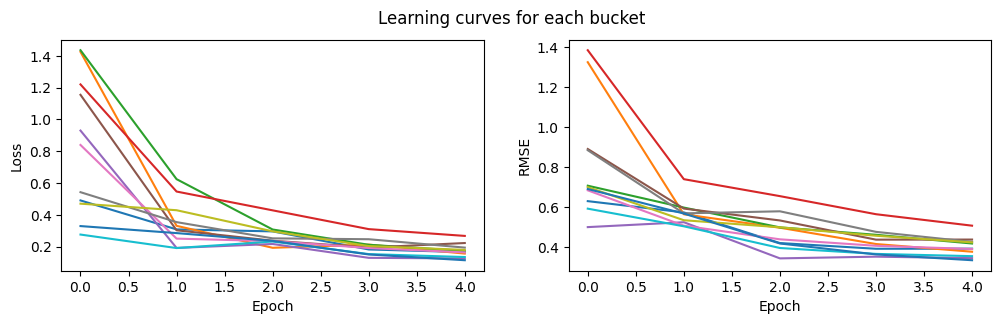

In [101]:
viz_learning_curve(results)

### 2.6 Checking that the Model Works on the Validation Data

With our LSTM model now trained, the next crucial step is to evaluate its performance on the validation data. This phase is essential for assessing how well the model generalizes to data it hasn't seen during training.

By testing the model on our validation split, we can:

- Verify the model's predictive accuracy against known outcomes.
- Identify any potential issues, such as overfitting to the training data.
- Make any necessary adjustments before the final evaluation on the test data.

The following code block will apply the `check_validation_period` function to each bucket in our validation set. This function not only tests the model's predictions but also checks the water balance of the system, ensuring that our model is providing realistic and reliable outputs.


Spigot NSE 0.226
Overflow NSE 0.7945
Mass into the system:  2503.2990413298753
Mass out or left over: 40610.47745128636
percent mass resudual: -1522%


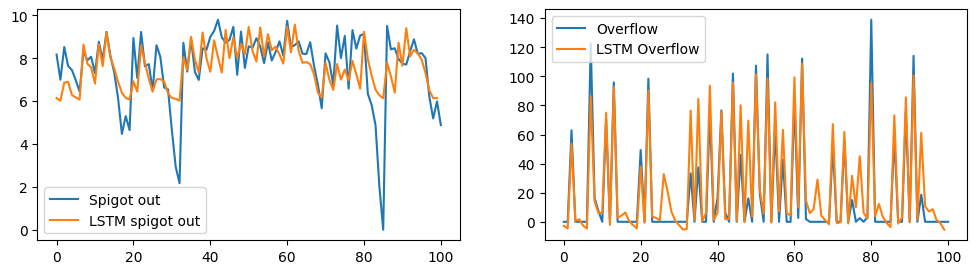

Spigot NSE 0.2973
Overflow NSE 0.6943
Mass into the system:  2053.225215640629
Mass out or left over: 31391.127560088782
percent mass resudual: -1429%


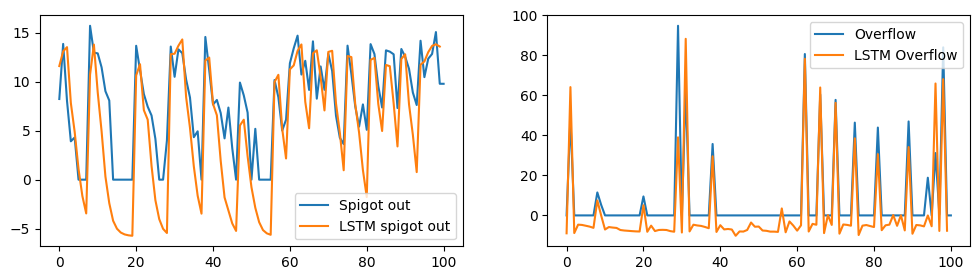

Spigot NSE 0.7908
Overflow NSE 0.7829
Mass into the system:  2313.3443730851513
Mass out or left over: 34527.63370251718
percent mass resudual: -1393%


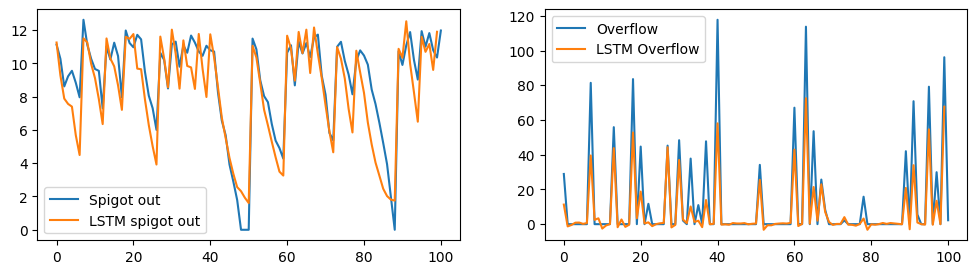

Spigot NSE 0.4554
Overflow NSE 0.8013
Mass into the system:  2173.173234861347
Mass out or left over: 35365.97146752319
percent mass resudual: -1527%


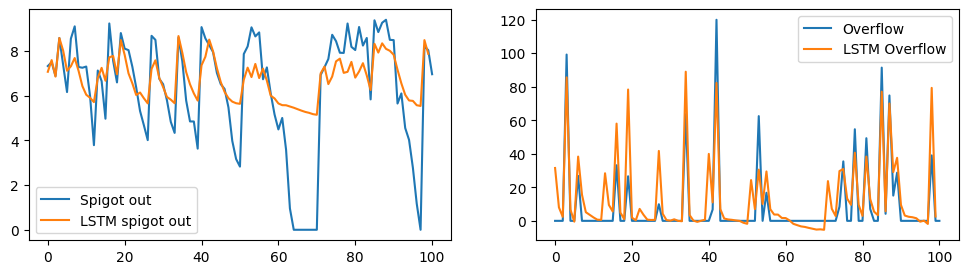

Spigot NSE -0.1474
Overflow NSE -0.0115
Mass into the system:  2584.4889031593443
Mass out or left over: 26752.177843383175
percent mass resudual: -935%


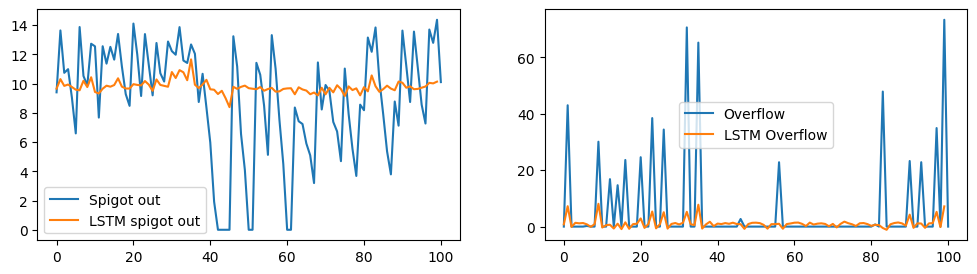

In [102]:
for ibuc in buckets_for_val:
    check_validation_period(lstm, np_val_seq_X, ibuc)

# 3. Clean up the code, add modularity, for easy use and modification

## 3.1 src
Contains the clean, modular code for the project, divided into several scripts:  
  - `data_generation.py`: Generates synthetic data simulating a leaking bucket hydrologic response.  
  - `lstm.py`: Implements the LSTM deep learning model.  
  - `model_controller.py`: Manages model functions such as training and data normalization.  
  - `validation.py`: Executes model validation and computes performance statistics.  
  - `vizualization.py`: Provides functionality for visualizing data and predictions.  
  
## 3.2 run

Includes Jupyter notebooks and scripts for direct execution of the model training and simulation:
  - `run_deep_bucket_lab_with_graphics.ipynb`: A Jupyter notebook with comprehensive visual outputs.
  - `run_deep_bucket_lab.py`: A script for running the model from the command line.

## 3.3 configuration

Stores configuration files that dictate model parameters and settings.

# 4. Experimentation

With our general leaky bucket model setup and training/validation framework in place, we now enter the experimentation phase. This stage allows us to explore various scenarios and understand how different configurations and settings impact the model's behavior and predictions.

Experimentation is key to gaining deeper insights into the dynamics of our hydrologic system and the capabilities of our LSTM model. It enables us to test hypotheses, explore 'what-if' scenarios, and refine our understanding of the system's responses under varied conditions.


In this phase, you're encouraged to experiment with variations in the bucket characteristics and modeling setup. Here are some ideas to get you started:

- **Data and system uncertainty**:
  - `./experiments/noise_iteration.py` Hosts a script designed to run a specific experiment testing model sensitivity to input noise.
- **Modifying Ground Truth Data**:
  - To simulate a more "flashy" system, you might reduce the probability of heavy precipitation and increase its magnitude.
  - For simulating smaller buckets, try reducing the size of the bucket attributes.
  - To add more variability, consider increasing the noise level from 0.1 to different values.

- **Adjusting the Modeling Setup**:
  - Experiment with the number of training buckets. Increasing or decreasing this number can show how the model performs with more or less training data.
  - Alter the length of the time series. This can help you understand the impact of short-term versus long-term data on the model's learning and predictions.

These modifications can lead to new insights and help you understand the robustness and adaptability of your model. Feel free to try out different combinations and observe how they affect the model's performance and outputs.

Head over to `deep_bucket_lab/experiments`
